In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from statsmodels.tsa import stattools
import pickle
import os
import zipfile
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.externals.joblib import dump, load
from google.colab import files

In [75]:
uploaded=files.upload()

Saving stock_price_VWXYZ.zip to stock_price_VWXYZ.zip


In [0]:
os.remove("stock_price_B.zip")

In [44]:
ls

 flop_k_seq  'portfolio (1)'  'portfolio (3)'   sample_data/        top_k_seq
 portfolio   'portfolio (2)'  'portfolio (4)'   stock_price_A.zip


In [0]:
zip_obj=zipfile.ZipFile("stock_price_VWXYZ.zip","r",zipfile.ZIP_DEFLATED)
zip_obj.extractall()
zip_obj.close()

In [77]:
ls

 A+1999-11-18+2018-02-28.csv       K+1990-01-02+2018-02-28.csv
 AAL+2005-09-27+2018-02-28.csv     KEY+1990-01-02+2018-02-28.csv
 AAP+2001-11-29+2018-02-28.csv     KHC+2015-07-06+2018-02-28.csv
 AAPL+1990-01-02+2018-02-28.csv    KIM+1991-11-22+2018-02-28.csv
 ABBV+2013-01-02+2018-02-28.csv    KLAC+1990-01-02+2018-02-28.csv
 ABC+1995-04-04+2018-02-28.csv     KMB+1990-01-02+2018-02-28.csv
 ABT+1990-01-02+2018-02-28.csv     KMI+2011-02-11+2018-02-28.csv
 ACN+2001-07-19+2018-02-28.csv     KMX+1997-02-04+2018-02-28.csv
 ADBE+1990-01-02+2018-02-28.csv    KO+1990-01-02+2018-02-28.csv
 ADI+1990-01-02+2018-02-28.csv     KR+1990-01-02+2018-02-28.csv
 ADM+1990-01-02+2018-02-28.csv     KSS+1992-05-19+2018-02-28.csv
 ADP+1990-01-02+2018-02-28.csv     KSU+1990-01-02+2018-02-28.csv
 ADS+2001-06-15+2018-02-28.csv     L+1990-01-02+2018-02-28.csv
 ADSK+1990-01-02+2018-02-28.csv    LB+1990-01-02+2018-02-28.csv
 AEE+1998-01-02+2018-02-28.csv     LEG+1990-01-02+2018-02-28.csv
 AEP+1990-01-02+2018-02-28.csv 

In [0]:
def retrieve_adj_close_price_data(directory="./"): # ./historical_data/
    """
    Retrieve daily adj close prices of all SP500 index constituent stocks and concatenate them into a DataFrame object
    """
    adj_price_list=[]
    for filename in os.listdir(directory):
        if filename[-4:] != ".csv":
            continue
        adj_close=pd.read_csv(directory+filename,index_col="Date",parse_dates=True)[["Adj Close"]]
        adj_close.columns=pd.Index([filename.split("+")[0]])
        adj_price_list.append(adj_close)
    return pd.concat(adj_price_list,axis=1,join='outer')

adj_close_price=retrieve_adj_close_price_data()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Stock DGX with the smallest non-missing value, count = 32.


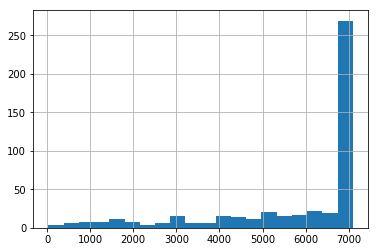

In [83]:
def simple_net_return_in_n_day_period(close_price,n_periods=1):
    """
    Calculate simple net return in a n-day period with formula R(t,n)=(P(t)-P(t-n))/P(t-n)
    """
    simple_return=close_price.diff(n_periods)/close_price.shift(n_periods)
    return simple_return[n_periods:]

daily_return=simple_net_return_in_n_day_period(adj_close_price,1)

# the number of non-missing value of  every stock
daily_return.describe().loc["count"].hist(bins=20)

# the ticker of stock with smallest non-missing value
ticker=np.argmin(daily_return.describe().loc["count"])
count=int(np.min(daily_return.describe().loc["count"]))
print("Stock {} with the smallest non-missing value, count = {}.".format(ticker,count))

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


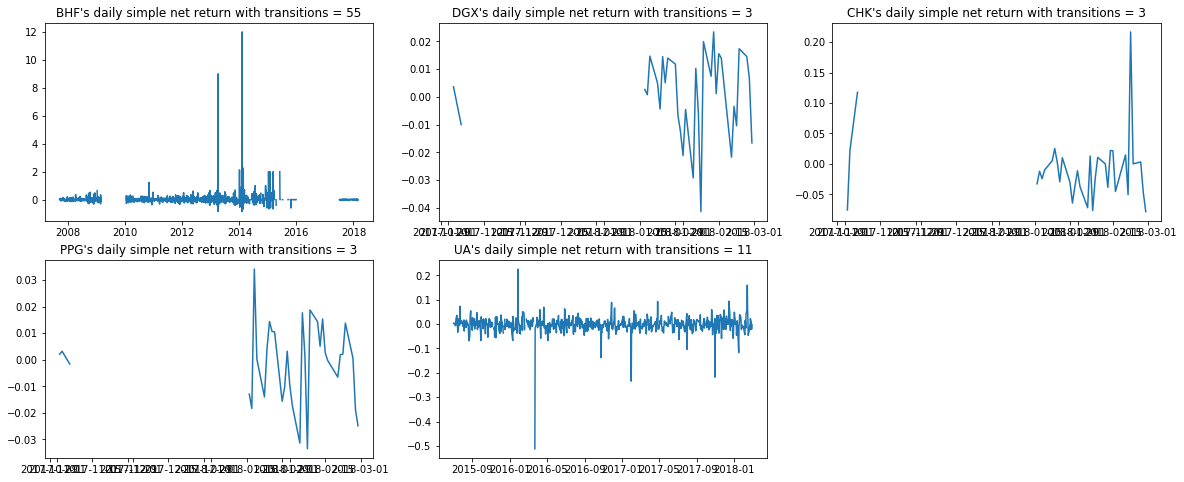

In [84]:
def abnormal_series_detection(daily_return):
    """
    Detect abnormal stock daily return time series, using the number of transitions from missing value (i.e. np.nan)
    to non-missing value or the reverse, since the normal transition number should be 0 (for stock listed since the 
    start of study period), 1 (for stock listed at start but then delisted OR stock not listed at start but then
    listed) or 2 (for stock not listed at start but then listed and finally delisted; another possibility belongs to
    abnormal, i.e. for stock listed at start but then delisted and finally listed again). And abnormal time series
    with more than 2 transitions may be related with suspending trading or other situations.
    """
    abnormal=daily_return.isna().astype(np.int32).diff(1)[1:].abs().sum(axis=0)  # a Series with length = stock_num
    abnormal_stocks=list(abnormal[abnormal>=2].index)
    num_rows=len(abnormal_stocks)//3+1
    plt.figure(figsize=(20,num_rows*4))
    for i,stock in enumerate(abnormal_stocks):
        plt.subplot(num_rows,3,i+1)
        plt.plot(daily_return[stock])
        plt.title("{}'s daily simple net return with transitions = {}".format(stock,int(abnormal[stock])))

abnormal_series_detection(daily_return)

In [0]:
def generate_sample_constituent_stock_matrix(daily_return_m):
    """
    Generate sample SP500 constituent stock binary matrix with element (i,j) denoting whether the j-th stock belongs
    to SP500 index at i-th month end (0=False, 1=True) before obtaining the actual constituent stock matrix
    """
    start=str(daily_return_m.index[0].year)+"-"+str(daily_return_m.index[0].month)
    end=str(daily_return_m.index[-1].year)+"-"+str(daily_return_m.index[-1].month)
    date_idx=pd.date_range(start,end,freq="M")
    stock_ticker=daily_return_m.columns
    return pd.DataFrame(np.ones((len(date_idx),len(stock_ticker)),np.int16),index=date_idx,columns=stock_ticker)

stock_consti=generate_sample_constituent_stock_matrix(daily_return)

In [0]:
def calculate_num_study_periods(total_days,train_period,trade_period):
    """
    Calculate the number of study periods given total available days, train period and trade period length
    """
    return (total_days-train_period)//trade_period

train_period=750
trade_period=250
sequence_length=240
num_study_period=calculate_num_study_periods(len(daily_return.index),train_period,trade_period)

In [0]:
def shift_one_month_ahead(time_point):
    """
    Shift the timestamp to the previous month's ending
    """
    return pd.Timestamp(str(time_point.year)+"-"+str(time_point.month)+"-"+"01",freq="M")-pd.Timedelta(1,"D")

In [0]:
def generate_target_value(input_array):
    """
    Generate target value for input array with those stocks the return of which is larger than the median level set 
    to positive value and the other stocks the return of which is smaller than the median level set to negative value
    at each current timestep
    """
    input_array[:,:,-1]=input_array[:,:,-1]-np.nanmedian(input_array[:,:,-1],axis=1,keepdims=True)
    return input_array

In [0]:
def exclude_missing_value(input_array):
    """
    Exclude missing value (including missing return information at pervious timesteps or missing target value) and 
    flatten 3-D array (num_timesteps, num_stocks, sequence_len) into 2-D array (num_instances, sequence_len)
    """
    nan_matrix=(np.sum(np.isnan(input_array),axis=2)==0)
    nan_ratio=100-np.sum(nan_matrix)/(nan_matrix.shape[0]*nan_matrix.shape[1])*100
    print("There are {:.2f}% missing values in constructed sequences!".format(nan_ratio))
    exclude_nan=input_array[nan_matrix]
    return exclude_nan,nan_matrix

In [0]:
def generate_train_trade_set_each_study_period(return_m,stock_m,train_period,trade_period,sequence_len,
                                               study_period_idx,save_directory="./train_trade_set"):
    """
    
    """
    # obtain the up-to-date (previous month end) list of SP500 constituent stocks at the last day of train period
    train_period_end_idx=study_period_idx*trade_period+train_period-1
    train_period_end_date=return_m.index[train_period_end_idx]
    train_period_end_prev_month=shift_one_month_ahead(train_period_end_date)
    stock_list=stock_m.iloc[stock_m.index.get_loc(train_period_end_prev_month)] # a Series with length = stock_num
    
    # obtain the return series of SP500 constituent stocks (may have slight diff to reality) in this study period
    start_idx=study_period_idx*trade_period
    end_idx=(study_period_idx+1)*trade_period+train_period
    return_sp500=return_m[stock_list[stock_list==1].index].iloc[start_idx:end_idx]
        
    # standardize return series using train set's mean return and stdev
    return_train_array=return_sp500.iloc[:train_period].values
    miu=np.nanmean(return_train_array)
    sigma=np.nanstd(return_train_array)
    return_std=(return_sp500-miu)/sigma
    
    # transform return series from DataFrame to Ndarray and add the timesteps dimension (axis=2)
    return_array=return_std.values
    return_column=return_std.columns
    return_add_dims=np.expand_dims(return_array,axis=2)
    
    # construct train and trade set with return information at pervious "sequence_len" timesteps
    shifted_list=[return_add_dims]
    for t in range(sequence_len):
        shifted_list.append(np.roll(return_add_dims,shift=t+1,axis=0))
    shifted_list_r=list(reversed(shifted_list))
    return_concat=np.concatenate(shifted_list_r,axis=2)
    return_train_set=return_concat[sequence_len:train_period,:,:]
    return_trade_set=return_concat[train_period:,:,:]
        
    # generate target value (positive when outperform median level and negative when underperform median level)
    return_train_set_label=generate_target_value(return_train_set)
    return_trade_set_label=generate_target_value(return_trade_set)
    
    # print(return_train_set_label[:,:,-1])
    # print(return_trade_set_label[:,:,-1])
    
    # exclude missing value and flatten 3-D array into 2-D array
    return_train_set_nonan,_=exclude_missing_value(return_train_set_label)
    return_trade_set_nonan,nonan_identifier=exclude_missing_value(return_trade_set_label)  
    
    # separate features (X) and target (Y) and transform target in binary value (1 = positive, 0 = negative)
    return_train_set_X=return_train_set_nonan[:,:-1]
    return_train_set_Y=(return_train_set_nonan[:,-1]>=0).astype(np.int32)
    return_trade_set_X=return_trade_set_nonan[:,:-1]
    return_trade_set_Y=(return_trade_set_nonan[:,-1]>=0).astype(np.int32)
     
    # save train, trade set and non-nan identifier of trade set using pickle binary format 
    pickle.dump(return_train_set_X,open(save_directory+"/return_train_X_"+str(study_period_idx),"wb"))
    pickle.dump(return_train_set_Y,open(save_directory+"/return_train_Y_"+str(study_period_idx),"wb"))
    pickle.dump(return_trade_set_X,open(save_directory+"/return_trade_X_"+str(study_period_idx),"wb"))
    pickle.dump(return_trade_set_Y,open(save_directory+"/return_trade_Y_"+str(study_period_idx),"wb"))
    pickle.dump(nonan_identifier,open(save_directory+"/nonan-identifier_for_trade_"+str(study_period_idx),"wb"))
    pickle.dump((miu,sigma),open(save_directory+"/return_miu_sigma_"+str(study_period_idx),"wb"))

In [0]:
def generate_train_trade_set_each_study_period_benchmark(adj_close_price,stock_m,train_period,trade_period,
                                                         study_period_idx,save_directory="./train_trade_set"):
    """
    
    """
    # obtain the up-to-date (previous month end) list of SP500 constituent stocks at the last day of train period
    train_period_end_idx=study_period_idx*trade_period+train_period-1
    train_period_end_date=adj_close_price[1:].index[train_period_end_idx]
    train_period_end_prev_month=shift_one_month_ahead(train_period_end_date)
    stock_list=stock_m.iloc[stock_m.index.get_loc(train_period_end_prev_month)] # a Series with length = stock_num
    
    # obtain the adj close price series of SP500 constituent stocks (may have slight diff to reality) in this study period
    start_idx=study_period_idx*trade_period
    end_idx=(study_period_idx+1)*trade_period+train_period+1
    price_sp500=adj_close_price[stock_list[stock_list==1].index].iloc[start_idx:end_idx]
    
    # calculate n_period return to construct input features
    return_list=[simple_net_return_in_n_day_period(price_sp500,1)]
    for n_periods in list(np.linspace(1,20,20))+list(np.linspace(40,240,11)):
        return_n_period=simple_net_return_in_n_day_period(price_sp500,int(n_periods))
        return_list.append(return_n_period.shift(1,axis=0))
    return_frame=pd.concat(list(reversed(return_list)),axis=1,join="outer")
    
    # construct train and trade set with n_period return information at pervious timesteps    
    num_stock=np.sum(stock_list==1)
    shifted_list=[]
    for idx in range(len(return_frame.columns)//num_stock):
        return_array=return_frame.iloc[:,idx*num_stock:(idx+1)*num_stock].values
        # standardize return series using train set's mean return and stdev
        miu=np.nanmean(return_array[:train_period])
        sigma=np.nanstd(return_array[:train_period])
        return_std=np.expand_dims((return_array-miu)/sigma,axis=2)
        shifted_list.append(return_std)
    return_concat=np.concatenate(shifted_list,axis=2)
    return_train_set=return_concat[240:train_period,:,:]
    return_trade_set=return_concat[train_period:,:,:]
        
    # generate target value (positive when outperform median level and negative when underperform median level)
    return_train_set_label=generate_target_value(return_train_set)
    return_trade_set_label=generate_target_value(return_trade_set)
    
    # print(return_train_set_label[:,:,-1])
    # print(return_trade_set_label[:,:,-1])
    
    # exclude missing value and flatten 3-D array into 2-D array
    return_train_set_nonan,_=exclude_missing_value(return_train_set_label)
    return_trade_set_nonan,nonan_identifier=exclude_missing_value(return_trade_set_label)  
    
    # separate features (X) and target (Y) and transform target in binary value (1 = positive, 0 = negative)
    return_train_set_X=return_train_set_nonan[:,:-1]
    return_train_set_Y=(return_train_set_nonan[:,-1]>=0).astype(np.int32)
    return_trade_set_X=return_trade_set_nonan[:,:-1]
    return_trade_set_Y=(return_trade_set_nonan[:,-1]>=0).astype(np.int32)
     
    # save train, trade set and non-nan identifier of trade set using pickle binary format 
    pickle.dump(return_train_set_X,open(save_directory+"/return_train_X_"+str(study_period_idx),"wb"))
    pickle.dump(return_train_set_Y,open(save_directory+"/return_train_Y_"+str(study_period_idx),"wb"))
    pickle.dump(return_trade_set_X,open(save_directory+"/return_trade_X_"+str(study_period_idx),"wb"))
    pickle.dump(return_trade_set_Y,open(save_directory+"/return_trade_Y_"+str(study_period_idx),"wb"))
    pickle.dump(nonan_identifier,open(save_directory+"/nonan-identifier_for_trade_"+str(study_period_idx),"wb"))

In [160]:
data_directory_rnn="./train_trade_set/LSTM_RNN"
os.makedirs(data_directory_rnn,exist_ok=True)

for i in range(num_study_period):
    print("Generating train and trade set of LSTM RNN for {}-th study period...".format(i))
    generate_train_trade_set_each_study_period(daily_return,stock_consti,train_period,trade_period,sequence_length,i,
                                               data_directory_rnn)

Generating train and trade set of LSTM RNN for 0-th study period...
There are 44.12% missing values in constructed sequences!
There are 40.50% missing values in constructed sequences!
Generating train and trade set of LSTM RNN for 1-th study period...
There are 42.08% missing values in constructed sequences!
There are 38.18% missing values in constructed sequences!
Generating train and trade set of LSTM RNN for 2-th study period...
There are 39.40% missing values in constructed sequences!
There are 34.81% missing values in constructed sequences!
Generating train and trade set of LSTM RNN for 3-th study period...
There are 36.56% missing values in constructed sequences!
There are 32.33% missing values in constructed sequences!
Generating train and trade set of LSTM RNN for 4-th study period...
There are 33.62% missing values in constructed sequences!
There are 29.59% missing values in constructed sequences!
Generating train and trade set of LSTM RNN for 5-th study period...
There are 31

In [161]:
data_directory_dnn="./train_trade_set/benchmark"
os.makedirs(data_directory_dnn,exist_ok=True)

for i in range(num_study_period):
    print("Generating train and trade set of benchmark models for {}-th study period...".format(i))
    generate_train_trade_set_each_study_period_benchmark(adj_close_price,stock_consti,train_period,trade_period,i,
                                                         data_directory_dnn)

Generating train and trade set of benchmark models for 0-th study period...
There are 44.12% missing values in constructed sequences!
There are 40.50% missing values in constructed sequences!
Generating train and trade set of benchmark models for 1-th study period...
There are 42.08% missing values in constructed sequences!
There are 38.18% missing values in constructed sequences!
Generating train and trade set of benchmark models for 2-th study period...
There are 39.40% missing values in constructed sequences!
There are 34.81% missing values in constructed sequences!
Generating train and trade set of benchmark models for 3-th study period...
There are 36.56% missing values in constructed sequences!
There are 32.33% missing values in constructed sequences!
Generating train and trade set of benchmark models for 4-th study period...
There are 33.62% missing values in constructed sequences!
There are 29.59% missing values in constructed sequences!
Generating train and trade set of benchm

In [0]:
def construct_rnn_model(sequence_length):
    X_input=keras.layers.Input(shape=(sequence_length,1))
    X=keras.layers.CuDNNLSTM(25)(X_input)
    X=keras.layers.Dropout(0.1)(X)
    X=keras.layers.Dense(1,activation="sigmoid")(X)
    model=keras.models.Model(inputs=X_input,outputs=X)
    return model

In [0]:
def lstm_rnn(train_X,train_Y,trade_X,trade_Y,sequence_len,study_period_idx,to_directory):
    """
    Construct, compile, train LSTM RNN model and then use it to predict
    """
    # construct LSTM RNN model
    keras.backend.clear_session()
    model=construct_rnn_model(sequence_len)
    
    # compile LSTM RNN model
    model.compile(optimizer=keras.optimizers.Adam(0.001),loss=keras.losses.binary_crossentropy,metrics=["accuracy"])
    
    # fit(train) LSTM RNN model
    model.fit(train_X,train_Y,batch_size=1000,epochs=1000,verbose=0,validation_split=0.2,callbacks=
              [keras.callbacks.EarlyStopping("val_loss",patience=50,restore_best_weights=True),keras.callbacks.
               ModelCheckpoint(to_directory+"/study-"+str(study_period_idx)+"weights.{epoch:02d}-{val_loss:.2f}.hdf5",
                               monitor="val_loss",save_best_only=True)])
    
    # evaluate LSTM RNN model
    model.evaluate(trade_X,trade_Y)
    
    # generate probability predictions of trade set
    pred_prob=model.predict(trade_X)
    
    return pred_prob

In [0]:
def construct_dnn_model(layer_dims):
    """
    """
    X_input=keras.layers.Input(shape=(layer_dims[0],))
    
    # the first hidden layer
    X=keras.layers.Dense(layer_dims[1],activation="relu",kernel_regularizer=keras.regularizers.l1(0.00001))(X_input)
    X=keras.layers.Dropout(0.5)(X)
    
    # the second hidden layer
    X=keras.layers.Dense(layer_dims[2],activation="relu",kernel_regularizer=keras.regularizers.l1(0.00001))(X)
    X=keras.layers.Dropout(0.5)(X)
    
    # the third hidden layer
    X=keras.layers.Dense(layer_dims[3],activation="relu",kernel_regularizer=keras.regularizers.l1(0.00001))(X)
    X=keras.layers.Dropout(0.5)(X) 
    
    # the output layer
    X=keras.layers.Dense(layer_dims[4],activation=None,kernel_regularizer=keras.regularizers.l1(0.00001))(X)
    
    model=keras.models.Model(inputs=X_input,outputs=X)
    
    return model

In [0]:
def dnn(train_X,train_Y,trade_X,trade_Y,study_period_idx,to_directory):
    """
    Construct, compile, train DNN model and then use it to predict
    """
    # construct DNN model
    keras.backend.clear_session()
    model=construct_dnn_model([31,31,10,5,1])
    
    # compile DNN model
    model.compile(optimizer=keras.optimizers.Adam(0.001),loss=keras.losses.binary_crossentropy,metrics=["accuracy"])
    
    # fit(train) DNN model
    model.fit(train_X,train_Y,batch_size=1000,epochs=1000,verbose=0,validation_split=0.2,callbacks=
              [keras.callbacks.EarlyStopping("val_loss",patience=50),keras.callbacks.
               ModelCheckpoint(to_directory+"/study-"+str(study_period_idx)+"weights.{epoch:02d}-{val_loss:.2f}.hdf5",
                               monitor="val_loss",save_best_only=True)]) # restore_best_weights=True
    
    # evaluate LSTM RNN model
    model.evaluate(trade_X,trade_Y)
    
    # generate probability predictions of trade set
    pred_prob=model.predict(trade_X)
    
    return pred_prob

In [0]:
def random_forest(train_X,train_Y,trade_X,study_period_idx,to_directory):
    """
    """
    rf_clf=RandomForestClassifier(n_estimators=1000,max_depth=20,bootstrap=True)
    rf_clf.fit(train_X,train_Y)
    pred_prob=rf_clf.predict_proba(trade_X)[:,1]
    
    # save model
    dump(rf_clf,to_directory+"/study-"+str(study_period_idx))
    
    return pred_prob

In [0]:
def logistic_regression(train_X,train_Y,trade_X,study_period_idx,to_directory):
    """
    """
    log_reg=LogisticRegression(penalty="l2",solver="lbfgs",max_iter=100)
    param_grid={"C":list(np.power(10,np.linspace(-4,4,101)))}
    grid_search=GridSearchCV(log_reg,param_grid,cv=5,scoring='neg_mean_squared_error')
    grid_search.fit(train_X,train_Y)
    pred_prob=grid_search.best_estimator_.predict_proba(trade_X)[:,1]
    
    # save model
    dump(grid_search.best_estimator_,to_directory+"/study-"+str(study_period_idx))
    
    return pred_prob

In [0]:
def construct_the_2k_portfolio(pred_prob_frame,k):
    portfolio=[]
    top_k_idx_1=[]
    top_k_idx_2=[]
    flop_k_idx_1=[]
    flop_k_idx_2=[]
    for i in range(len(pred_prob_frame.index)):
        count_nonan=np.sum(1-pred_prob_frame.iloc[0].isna().astype(np.int16)) # count the number of non-nan(这里为啥是iloc[0]而不是iloc[i])
        if count_nonan>=2*k:
            warning="nonan>=2k"
        elif (count_nonan<2*k) & (count_nonan>=k):
            warning="k<=nonan<2k"
            # print("Warning: not enough available stocks at date {}, k<=nonan<2k".format(pred_prob_frame.index[i]))
        else:
            warning="nonan<k"
            # print("Serious Warning: not enough available stocks at date {}, nonan<k".format(pred_prob_frame.index[i]))
            
        pred_prob_frame.sort_values(by=pred_prob_frame.index[i],axis=1,inplace=True,na_position="first")
        top_k=list(pred_prob_frame.columns[-k:])
        for ticker in top_k:
            top_k_idx_1.append(i)
            top_k_idx_2.append(pred_prob_frame.columns.get_loc(ticker))    
        
        pred_prob_frame.sort_values(by=pred_prob_frame.index[i],axis=1,inplace=True,na_position="last")
        flop_k=list(pred_prob_frame.columns[:k])
        for ticker in flop_k:
            flop_k_idx_1.append(i)
            flop_k_idx_2.append(pred_prob_frame.columns.get_loc(ticker))
        portfolio.append({"top_k":top_k,"flop_k":flop_k,"warning":warning})
        
    return portfolio,(top_k_idx_1,top_k_idx_2),(flop_k_idx_1,flop_k_idx_2)

In [0]:
def obtain_the_realized_return(portfolio,daily_return,adj_close):
    """
    for i in range(len(portfolio)):
        # note that the i-th date in adj_close is one day earlier of the i-th date in daily_return
        price_long=adj_close.iloc[i][portfolio[i]["top_k"]].sum()
        price_short=adj_close.iloc[i][portfolio[i]["flop_k"]].sum()
        weights_long=adj_close.iloc[i][portfolio[i]["top_k"]]/(price_long-price_short)
        rtn_from_long=(daily_return.iloc[i][portfolio[i]["top_k"]]*weights_long).sum()
        weights_short=-adj_close.iloc[i][portfolio[i]["flop_k"]]/(price_long-price_short)
        rtn_from_short=(daily_return.iloc[i][portfolio[i]["flop_k"]]*weights_short).sum()
        total_rtn=rtn_from_long+rtn_from_short
        if ((price_long-price_short<=0) & (total_rtn>0)) | ((price_long-price_short<0) & (total_rtn>=0)):
            portfolio[i]["arbitrage"]="Yes"
        portfolio[i]["return"]=total_rtn
    return portfolio
    """
  
    for i in range(len(portfolio)):
        rtn_from_long=daily_return.iloc[i][portfolio[i]["top_k"]].mean()
        rtn_from_short=-daily_return.iloc[i][portfolio[i]["flop_k"]].mean()
        portfolio[i]["return_long"]=rtn_from_long
        portfolio[i]["return_short"]=rtn_from_short
    return portfolio
        

In [0]:
def generate_portfolio_and_return(daily_return,adj_close,study_period_idx,sequence_len,model_type="RNN",
                                  from_directory="./train_trade_set",to_directory="./model_weights"):
    
    # retrieve train and trade set for current study period
    train_X=pickle.load(open(from_directory+"/return_train_X_"+str(study_period_idx),"rb"))
    train_Y=pickle.load(open(from_directory+"/return_train_Y_"+str(study_period_idx),"rb"))
    trade_X=pickle.load(open(from_directory+"/return_trade_X_"+str(study_period_idx),"rb"))
    trade_Y=pickle.load(open(from_directory+"/return_trade_Y_"+str(study_period_idx),"rb"))
    
    # retrieve non-nan identifier for trade set
    nonan_idf=pickle.load(open(from_directory+"/nonan-identifier_for_trade_"+str(study_period_idx),
                               "rb")).astype(np.float64)
    
    if model_type == "RNN":
        train_X=np.expand_dims(train_X,axis=2)
        train_Y=np.expand_dims(train_Y,axis=2)
        trade_X=np.expand_dims(trade_X,axis=2)
        trade_Y=np.expand_dims(trade_Y,axis=2)        
        pred_prob=lstm_rnn(train_X,train_Y,trade_X,trade_Y,sequence_len,study_period_idx,to_directory)
    
    elif model_type == "DNN":
        pred_prob=dnn(train_X,train_Y,trade_X,trade_Y,study_period_idx,to_directory)
    
    elif model_type == "RAF":
        pred_prob=random_forest(train_X,train_Y,trade_X,study_period_idx,to_directory)
    
    elif model_type == "LOG":
        pred_prob=logistic_regression(train_X,train_Y,trade_X,study_period_idx,to_directory)
    
    else:
        print("Model type must belong to ['RNN','DNN','RF','LOG']!")
        return None
    
    # using non-nan identifier to transform predictions from ndarray with shape (num_instances,1) into DataFrame with
    # shape (trade_period,num_stocks) and nan value denoting unavailable stocks or unavailable predictions
    pred_prob_with_nan=np.copy(nonan_idf)
    pred_prob_with_nan[pred_prob_with_nan==0]=np.nan
    pred_prob_with_nan[pred_prob_with_nan==1]=pred_prob.reshape(-1)
    pred_prob_frame=pd.DataFrame(pred_prob_with_nan,index=daily_return.index,columns=daily_return.columns)
    if model_type == "RNN":
        nonan_idf_3d=np.concatenate([np.expand_dims(nonan_idf,axis=2)]*sequence_len,axis=2)
        trade_X_with_nan=nonan_idf_3d
        trade_X_with_nan[trade_X_with_nan[:,:,0]==1]=trade_X[:,:,0]
    portfolio_dict={}
    for k in [10,50,100,150,200]:
        portfolio,top_k_idx,flop_k_idx=construct_the_2k_portfolio(pred_prob_frame,k)
        if (model_type == "RNN") & (k == 10):
            miu,sigma=pickle.load(open(from_directory+"/return_miu_sigma_"+str(study_period_idx),"rb"))
            top_10_seq=trade_X_with_nan[top_k_idx[0],top_k_idx[1],:]*sigma+miu
            flop_10_seq=trade_X_with_nan[flop_k_idx[0],flop_k_idx[1],:]*sigma+miu
        portfolio=obtain_the_realized_return(portfolio,daily_return,adj_close)
        portfolio_dict[k]=portfolio
    
    if model_type == "RNN":
        return portfolio_dict,top_10_seq,flop_10_seq
    else:
        return portfolio_dict

In [166]:
model_directory_rnn="./model_weights/recurrent_neural_network"
os.makedirs(model_directory_rnn,exist_ok=True)

portfolio_list_rnn=[]
top_k_seq_list=[]
flop_k_seq_list=[]
for i in range(2): # num_study_period)
    print("Generating the daily 2k portfolio and corresponding returns of LSTM RNN for {}-th study period...".format(i))
    trade_start=i*trade_period+train_period
    trade_end=(i+1)*trade_period+train_period
    portfolio_dict,top_k_seq,flop_k_seq=generate_portfolio_and_return(daily_return.iloc[trade_start:trade_end],
                                                                      adj_close_price[trade_start:trade_end],i,sequence_length,
                                                                      "RNN",data_directory_rnn,model_directory_rnn)
    portfolio_list_rnn.append(portfolio_dict)
    top_k_seq_list.append(top_k_seq)
    flop_k_seq_list.append(flop_k_seq)

top_k_seq_array=np.concatenate(top_k_seq_list,axis=0)
flop_k_seq_array=np.concatenate(flop_k_seq_list,axis=0)

Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 0-th study period...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Instructions for updating:
Use tf.cast instead.
71402/71402 [==============================] - 14s 201us/sample - loss: 0.6897 - acc: 0.5354
Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 1-th study period...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


74180/74180 [==============================] - 15s 205us/sample - loss: 0.6891 - acc: 0.5364


In [0]:
results_directory_rnn="./analysis_results/LSTM_RNN_results"
os.makedirs(results_directory_rnn,exist_ok=True)

pickle.dump(portfolio_list_rnn,open(results_directory_rnn+"/portfolio","wb"))
pickle.dump(top_k_seq_array,open(results_directory_rnn+"/top_k_seq","wb"))
pickle.dump(flop_k_seq_array,open(results_directory_rnn+"/flop_k_seq","wb"))

for filename in os.listdir(results_directory_rnn):
    files.download(results_directory_rnn+"/"+filename)  # 多个files.download()语句不能放在同一个代码框中

In [0]:
for filename in os.listdir(model_directory_rnn):
    files.download(model_directory_rnn+"/"+filename)

In [59]:
model_directory_dnn="./model_weights/deep_neural_network"
os.makedirs(model_directory_dnn,exist_ok=True)

portfolio_list_dnn=[]
for i in range(2): # num_study_period
    print("Generating the daily 2k portfolio and corresponding returns of deep neural network for {}-th study period...".format(i))
    trade_start=i*trade_period+train_period
    trade_end=(i+1)*trade_period+train_period
    portfolio_dict=generate_portfolio_and_return(daily_return.iloc[trade_start:trade_end],
                                                 adj_close_price[trade_start:trade_end],i,sequence_length,
                                                 "DNN",data_directory_dnn,model_directory_dnn)
    portfolio_list_dnn.append(portfolio_dict)

Generating the daily 2k portfolio and corresponding returns of deep neural network for 0-th study period...
71402/71402 [==============================] - 4s 59us/sample - loss: 0.6912 - acc: 0.5309
Generating the daily 2k portfolio and corresponding returns of deep neural network for 1-th study period...
74180/74180 [==============================] - 4s 53us/sample - loss: 0.6910 - acc: 0.5292


In [0]:
results_directory_dnn="./analysis_results/DNN_results"
os.makedirs(results_directory_dnn,exist_ok=True)

pickle.dump(portfolio_list_dnn,open(results_directory_dnn+"/portfolio","wb"))

for filename in os.listdir(results_directory_dnn):
    files.download(results_directory_dnn+"/"+filename)

In [0]:
for filename in os.listdir(model_directory_dnn):
    files.download(model_directory_dnn+"/"+filename)

In [73]:
data_directory_raf="./train_trade_set/benchmark"
model_directory_raf="./model_weights/random_forest"
os.makedirs(model_directory_raf,exist_ok=True)

portfolio_list_raf=[]
for i in range(2): # num_study_period
    print("Generating the daily 2k portfolio and corresponding returns of random forest for {}-th study period...".format(i))
    trade_start=i*trade_period+train_period
    trade_end=(i+1)*trade_period+train_period
    portfolio_dict=generate_portfolio_and_return(daily_return.iloc[trade_start:trade_end],
                                                 adj_close_price[trade_start:trade_end],i,sequence_length,
                                                 "RAF",data_directory_raf,model_directory_raf)
    portfolio_list_raf.append(portfolio_dict)

Generating the daily 2k portfolio and corresponding returns of random forest for 0-th study period...
Generating the daily 2k portfolio and corresponding returns of random forest for 1-th study period...


In [0]:
results_directory_raf="./analysis_results/RAF_results"
os.makedirs(results_directory_raf,exist_ok=True)

pickle.dump(portfolio_list_raf,open(results_directory_raf+"/portfolio","wb"))

for filename in os.listdir(results_directory_raf):
    files.download(results_directory_raf+"/"+filename)

In [0]:
for filename in os.listdir(model_directory_raf):
    files.download(model_directory_raf+"/"+filename)

In [61]:
data_directory_log="./train_trade_set/benchmark"
model_directory_log="./model_weights/logistic_regression"
os.makedirs(model_directory_log,exist_ok=True)

portfolio_list_log=[]
for i in range(2): # num_study_period
    print("Generating the daily 2k portfolio and corresponding returns of logistic regression for {}-th study period...".format(i))
    trade_start=i*trade_period+train_period
    trade_end=(i+1)*trade_period+train_period
    portfolio_dict=generate_portfolio_and_return(daily_return.iloc[trade_start:trade_end],
                                                 adj_close_price[trade_start:trade_end],i,sequence_length,
                                                 "LOG",data_directory_log,model_directory_log)
    portfolio_list_log.append(portfolio_dict)

Generating the daily 2k portfolio and corresponding returns of logistic regression for 0-th study period...
Generating the daily 2k portfolio and corresponding returns of logistic regression for 1-th study period...
Generating the daily 2k portfolio and corresponding returns of logistic regression for 2-th study period...


KeyboardInterrupt: ignored

In [0]:
results_directory_log="./analysis_results/LOG_results"
os.makedirs(results_directory_log,exist_ok=True)

pickle.dump(portfolio_list_log,open(results_directory_log+"/portfolio","wb"))

for filename in os.listdir(results_directory_log):
    files.download(results_directory_log+"/"+filename)

In [0]:
for filename in os.listdir(model_directory_log):
    files.download(model_directory_log+"/"+filename)

In [34]:
uploaded=files.upload()

Saving portfolio to portfolio (4)


In [22]:
ls

 flop_k_seq  'portfolio (1)'  'portfolio (3)'   top_k_seq
 portfolio   'portfolio (2)'   sample_data/


In [0]:
portfolio_list_rnn=pickle.load(open("portfolio (4)","rb"))
portfolio_list_dnn=pickle.load(open("portfolio","rb"))
portfolio_list_raf=pickle.load(open("portfolio (2)","rb"))
portfolio_list_log=pickle.load(open("portfolio (3)","rb"))
top_k_seq=pickle.load(open("top_k_seq","rb"))
flop_k_seq=pickle.load(open("flop_k_seq","rb"))

In [0]:
def construct_analysis_tables(portfolio_list,daily_return,train_period,trade_period):
    """
    Need debug!!!!!!!
    """
    analysis_tables={}
    for k in portfolio_list[0].keys():
        analysis_tables[k]=[]
    for idx,portfolio_i_period in enumerate(portfolio_list):
        for k,portfolio_list in portfolio_i_period.items():
            start=idx*trade_period+train_period
            end=(idx+1)*trade_period+train_period
            portfolio_frame=pd.DataFrame(portfolio_list,index=daily_return.index[start:end])
            portfolio_column=pd.DataFrame([idx]*(end-start),index=daily_return.index[start:end],
                                          columns=["Study period"])
            analysis_tables[k].append(pd.concat([portfolio_frame,portfolio_column],axis=1))
    for k,portfolio_list in analysis_tables.items():
        analysis_tables[k]=pd.concat(portfolio_list,axis=0)
    return analysis_tables

analysis_table_dict={}
analysis_table_rnn=construct_analysis_tables(portfolio_list_rnn,daily_return,train_period,trade_period)
analysis_table_dict["RNN"]=analysis_table_rnn
analysis_table_dnn=construct_analysis_tables(portfolio_list_dnn,daily_return,train_period,trade_period)
analysis_table_dict["DNN"]=analysis_table_dnn
analysis_table_raf=construct_analysis_tables(portfolio_list_raf,daily_return,train_period,trade_period)
analysis_table_dict["RAF"]=analysis_table_raf
analysis_table_log=construct_analysis_tables(portfolio_list_log,daily_return,train_period,trade_period)
analysis_table_dict["LOG"]=analysis_table_log

In [121]:
analysis_table_dict["RNN"][10]

,flop_k,return_long,return_short,top_k,warning,Study period
Date,,,,,,
1992-12-18,"[SIG, INTC, LOW, MSI, SWK, MRO, HRB, AFL, VZ, ...",0.011952,0.011802,"[IP, F, PHM, BBY, MMM, NOC, IBM, CSCO, PKI, COO]",nonan>=2k,0
1992-12-21,"[INTC, LOW, LUV, BBT, UNH, DWDP, C, EA, CELG, ...",0.017792,-0.000993,"[ROST, LH, FISV, STT, TAP, COO, EXPD, BBY, SWK...",nonan>=2k,0
1992-12-22,"[SIG, INTC, LUV, BBT, EA, SWK, SYY, LOW, VZ, DVN]",0.009975,0.012445,"[PRGO, CERN, WMT, CDNS, AMAT, APH, LH, IBM, ST...",nonan>=2k,0
1992-12-23,"[COO, EA, INTC, XRAY, HBAN, LUV, PBCT, SWKS, S...",0.060798,-0.001629,"[DRE, IBM, ORCL, CERN, BBY, APH, OMC, GLW, BII...",nonan>=2k,0
1992-12-24,"[HBAN, COO, ORCL, EA, BA, SIG, XRAY, PBCT, APH...",0.007088,0.012021,"[K, REGN, CERN, EXPD, BMY, MNST, CELG, GLW, IP...",nonan>=2k,0
1992-12-28,"[HBAN, APH, HOLX, BA, WDC, USB, COO, DE, RTN, ...",-0.003511,-0.001332,"[VFC, SYY, REGN, BDX, CERN, UNH, K, GLW, SWKS,...",nonan>=2k,0
1992-12-29,"[APH, WDC, USB, HOLX, MNST, COG, DE, LEG, BA, ...",0.011226,0.000070,"[EIX, CELG, HRB, CERN, LRCX, OXY, UNH, PBCT, S...",nonan>=2k,0
1992-12-30,"[WDC, LEG, DE, USB, EA, IPG, MNST, PKI, TIF, BK]",-0.006157,0.011215,"[SO, CPB, PBCT, DRE, VRTX, DUK, PSA, BBY, MMM,...",nonan>=2k,0
1992-12-31,"[TIF, DE, LEG, EA, ROST, VNO, ZION, OMC, JWN, ...",-0.004439,0.003646,"[INTC, EXC, PPL, APH, MNST, HOLX, VRTX, PBCT, ...",nonan>=2k,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater


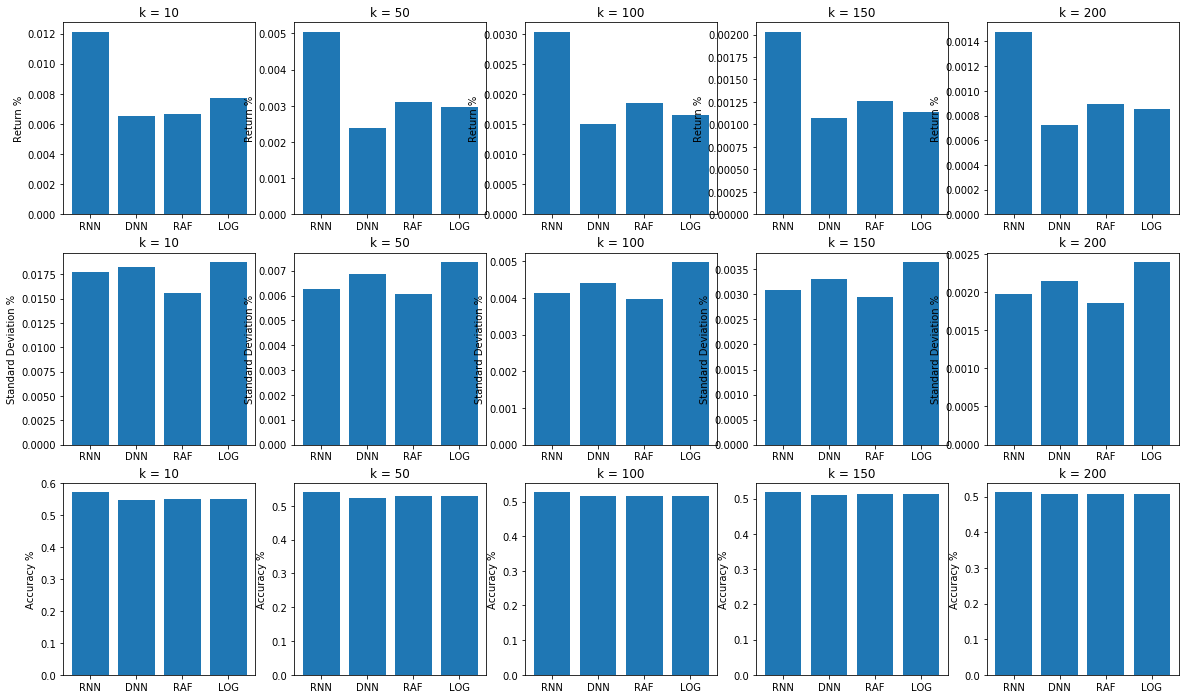

In [150]:
def analysis_model_performance(analysis_table_dict,daily_return,return_series=False):
    """
    Need debug!!!!!!
    """
    # create empty DataFrame to record analysis results
    index=list(analysis_table_dict.keys())
    columns=list(analysis_table_dict[index[0]].keys())
    mean_rtn_frame=pd.DataFrame(np.zeros((len(index),len(columns))),index=index,columns=columns)
    stdv_rtn_frame=pd.DataFrame(np.zeros((len(index),len(columns))),index=index,columns=columns)
    sharpe_r_frame=pd.DataFrame(np.zeros((len(index),len(columns))),index=index,columns=columns)
    accuracy_frame=pd.DataFrame(np.zeros((len(index),len(columns))),index=index,columns=columns)
    
    # conduct analysis
    time_series={}
    for model_n,analysis_t in analysis_table_dict.items():
        time_series[model_n]=[[],[]]  # the first [] records actual values and the second [] records predicted values
        for k,analysis in analysis_t.items():
            mean_rtn_frame.loc[model_n,k]=np.mean(analysis["return_long"]+analysis["return_short"])
            stdv_rtn_frame.loc[model_n,k]=np.std(analysis["return_long"]+analysis["return_short"])
            target=pd.DataFrame((daily_return.values-np.nanmedian(daily_return,axis=1,keepdims=True))>0,
                                index=daily_return.index,columns=daily_return.columns)
            correct_num=0
            for i in range(len(analysis["top_k"])):
                if (k==10) & return_series:
                    time_series[model_n][0].extend([1]*k)
                    time_series[model_n][1].extend(target.iloc[i][analysis["top_k"].iloc[i]])
                correct_num+=np.sum(target.iloc[i][analysis["top_k"].iloc[i]])
                # up_num+=np.sum(target.iloc[i][analysis["top_k"].iloc[i]])
            for i in range(len(analysis["flop_k"])):
                if (k==10) & return_series:
                    time_series[model_n][0].extend([0]*k)
                    time_series[model_n][1].extend(target.iloc[i][analysis["flop_k"].iloc[i]])
                correct_num+=np.sum(1-target.iloc[i][analysis["flop_k"].iloc[i]])
                # up_num+=np.sum(target.iloc[i][analysis["flop_k"].iloc[i]])
            accuracy_frame.loc[model_n,k]=correct_num/(2*k*len(daily_return.index))
    
    # plot figures
    plt.figure(figsize=(20,3*4))
    hor_num=len(columns)
    for i in range(hor_num):
        plt.subplot(3,hor_num,0*hor_num+i+1)
        plt.bar(mean_rtn_frame.index,mean_rtn_frame.iloc[:,i].values)
        plt.title("k = "+str(columns[i]))
        plt.ylabel("Return %")
    for i in range(hor_num):
        plt.subplot(3,hor_num,1*hor_num+i+1)
        plt.bar(stdv_rtn_frame.index,stdv_rtn_frame.iloc[:,i].values)
        plt.title("k = "+str(columns[i]))
        plt.ylabel("Standard Deviation %")
    for i in range(hor_num):
        plt.subplot(3,hor_num,2*hor_num+i+1)
        plt.bar(accuracy_frame.index,accuracy_frame.iloc[:,i].values)  
        plt.title("k = "+str(columns[i]))
        plt.ylabel("Accuracy %")
            
    return time_series
  
start_idx=train_period
end_idx=trade_period*2+train_period  # 注意最后把2换成num_study_period
time_series=analysis_model_performance(analysis_table_dict,daily_return.iloc[start_idx:end_idx],True)

In [131]:
def Pesaran_Timmermann_test(target_series,forecaster_series):
    """
    Perform Pesaran Timmermann test given the target series (binary) and forecaster series (binary)
    following the guide from http://www.real-statistics.com/time-series-analysis/forecasting-accuracy/pesaran-timmermann-test/
    Already passed the unit test!
    """
    p_y=np.mean(target_series)
    p_z=np.mean(forecaster_series)
    p_yz=np.mean(np.array(target_series)*np.array(forecaster_series)+
                 (1-np.array(target_series))*(1-np.array(forecaster_series)))
    n=len(target_series)
    
    q_y=p_y*(1-p_y)/n
    q_z=p_z*(1-p_z)/n
    p=p_y*p_z+(1-p_y)*(1-p_z)
    v=p*(1-p)/n
    w=(2*p_y-1)**2*q_z+(2*p_z-1)**2*q_y+4*q_y*q_z
    PT=(p_yz-p)/(v-w)**0.5
    p_value=1-scipy.stats.norm(0,1).cdf(PT)
    print("The p-value of PT statistics is {}".format(p_value))
    
for model_n,series in time_series.items():
    print("Peforming Pesaran Timmermann test for {} with 10 long and 10 short stock portfolio:".format(model_n))
    Pesaran_Timmermann_test(series[0],series[1])

Peforming Pesaran Timmermann test for RNN with 10 long and 10 short stock portfolio:
The p-value of PT statistics is 0.0
Peforming Pesaran Timmermann test for DNN with 10 long and 10 short stock portfolio:
The p-value of PT statistics is 0.0
Peforming Pesaran Timmermann test for RAF with 10 long and 10 short stock portfolio:
The p-value of PT statistics is 0.0
Peforming Pesaran Timmermann test for LOG with 10 long and 10 short stock portfolio:
The p-value of PT statistics is 0.0


In [134]:
def Diebold_Mariano_test(target_series,forecaster_1,forecaster_2):
    """
    Perform Diebold Mariano test given the target series (binary) and forecasted series (binary) of two models
    following the guide from http://www.real-statistics.com/time-series-analysis/forecasting-accuracy/diebold-mariano-test/
    Already passed the unit test!
    """
    # transform list to 1-D array
    target_array=np.array(target_series)
    forecaster_1_array=np.array(forecaster_1)
    forecaster_2_array=np.array(forecaster_2)
    n=len(target_array)
    
    # calculate loss-differential series and its auto-covariance
    loss_1=target_array-forecaster_1_array
    loss_2=target_array-forecaster_2_array
    loss_diff=loss_1**2-loss_2**2
    loss_acov=stattools.acovf(loss_diff)
    
    # calculate DM statistics
    if n**(1/3)+1-int(n**(1/3)+1)>=0.5:
        h=int(n**(1/3)+1)+1
    else:
        h=int(n**(1/3)+1)
    numerator=np.mean(loss_diff)
    denominator=((loss_acov[0]+2*np.sum(loss_acov[1:h]))/n)**0.5
    DM=numerator/denominator
    
    # calculate the p-value of DM statistics
    if numerator>0:
        p_value=(1-scipy.stats.norm(0,1).cdf(DM))*2
    else:
        p_value=scipy.stats.norm(0,1).cdf(DM)*2
    print("The p-value of DM statistics is {}".format(p_value))
    
    return DM,p_value
    
model_n_list=list(time_series.keys())
for i in range(len(model_n_list)):
    for j in range(i+1,len(model_n_list)):
        print("Performing Diebold Mariano test for {} and {} with 10 long and 10 short stock portfolio:".
              format(model_n_list[i],model_n_list[j]))
        target_series=time_series[model_n_list[i]][0]
        forecaster_1=time_series[model_n_list[i]][1]
        forecaster_2=time_series[model_n_list[j]][1]
        DM,p_value=Diebold_Mariano_test(target_series,forecaster_1,forecaster_2)
        if p_value>=0.05:
            print("There is no significant difference between the forecast power of {} and {} at 0.05 significance level".
                  format(model_n_list[i],model_n_list[j]))
        else:
            if DM>0:
                print("The forecast power of {} is significantly higher than {} at 0.05 significance level".
                      format(model_n_list[j],model_n_list[i]))
            else:
                print("The forecast power of {} is significantly higher than {} at 0.05 significance level".
                      format(model_n_list[i],model_n_list[j]))

Performing Diebold Mariano test for RNN and DNN with 10 long and 10 short stock portfolio:
The p-value of DM statistics is 4.572592426869807e-05
The forecast power of RNN is significantly higher than DNN at 0.05 significance level
Performing Diebold Mariano test for RNN and RAF with 10 long and 10 short stock portfolio:
The p-value of DM statistics is 5.6756857511159956e-05
The forecast power of RNN is significantly higher than RAF at 0.05 significance level
Performing Diebold Mariano test for RNN and LOG with 10 long and 10 short stock portfolio:
The p-value of DM statistics is 0.0001995274804994341
The forecast power of RNN is significantly higher than LOG at 0.05 significance level
Performing Diebold Mariano test for DNN and RAF with 10 long and 10 short stock portfolio:
The p-value of DM statistics is 0.6456311995202069
There is no significant difference between the forecast power of DNN and RAF at 0.05 significance level
Performing Diebold Mariano test for DNN and LOG with 10 long

In [0]:
def prob_random_guess(num_pred,accu_pred):
    """
    Calculate the probability of random guess achieving higher accuracy than a given accuracy
    It's ok
    """
    prob_success=0.5
    miu=num_pred*prob_success
    sigma=(num_pred*prob_success*(1-prob_success))**0.5
    better_prob=1-scipy.stats.norm(miu,sigma).cdf(int(accu_pred*num_pred))
    print("The probability of random guess achieving higher accuracy than {} is {}".format(accu_pred,better_prob))

CPU times: user 47.7 s, sys: 183 ms, total: 47.9 s
Wall time: 47.9 s


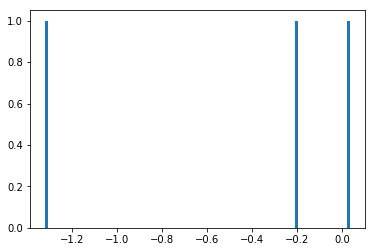

In [136]:
def monkey_throwing_darts(adj_close_price,daily_return,stock_consti,start_idx,end_idx,k,num_iter=100000):
    """
    It's OK but too slow
    """
    merged=pd.merge(daily_return,stock_consti,how="left",left_index=True,right_index=True)
    merged.columns=daily_return.columns.append(daily_return.columns)
    stock_consti_fillna=merged.iloc[:,len(merged.columns)//2:].fillna(method="ffill")
    
    daily_return_trunc=daily_return.iloc[start_idx:end_idx]
    close_prices_trunc=adj_close_price.iloc[start_idx:end_idx]
    stock_consti_trunc=stock_consti_fillna.iloc[start_idx:end_idx]
    
    return_list=[]
    for i in range(len(daily_return_trunc.index)):
        close_prices_i=close_prices_trunc.iloc[i]
        stock_consti_i=stock_consti_trunc.iloc[i]
        selector_1=stock_consti_i[stock_consti_i==1]
        daily_return_i=daily_return_trunc.iloc[i]
        selector_2=daily_return_i[(1-pd.isna(daily_return_i)).astype(np.bool)]
        stock_avail=list(set(selector_1.index) & set(selector_2.index))
        daily_return_array=pd.concat([daily_return_i[stock_avail]]*num_iter,axis=1).values.T
        close_prices_array=pd.concat([close_prices_i[stock_avail]]*num_iter,axis=1).values.T
        select_list_2=[]
        select_list_1=[]
        for j in range(num_iter):
            select_list_2.extend(np.random.permutation(len(stock_avail)))
            select_list_1.extend([j]*len(stock_avail))
        stock_2k_return=daily_return_array[select_list_1,select_list_2].reshape(num_iter,-1)[:,:2*k]
        stock_2k_prices=close_prices_array[select_list_1,select_list_2].reshape(num_iter,-1)[:,:2*k]
        stock_2k_prices[:,:k]=-stock_2k_prices[:,:k]
        stock_2k_weight=stock_2k_prices/np.sum(stock_2k_prices,axis=1,keepdims=True)
        return_i=np.sum(stock_2k_return*stock_2k_weight,axis=1,keepdims=True)  # shape=(num_iter,1)
        return_list.append(return_i)
    mean_return=np.mean(np.concatenate(return_list,axis=1),axis=1)
    
    plt.hist(mean_return,bins=100)
    
start_idx=train_period
end_idx=trade_period*num_study_period+train_period
%time monkey_throwing_darts(adj_close_price,daily_return,stock_consti,start_idx,end_idx,10,3)

In [153]:
def analysis_return_characteristics(analysis_table_dict,k=10):
    for model_n,analysis_table in analysis_table_dict.items():
        return_total=analysis_table[k]["return_long"]+analysis_table[k]["return_short"]
        return_total.name="return_total"
        analysis_table[k]=pd.concat([analysis_table[k],return_total],axis=1)
        print("Return characteristics of {} before transaction cost".format(model_n))
        print(analysis_table[k][["return_total","return_long","return_short"]].describe())
        print("Risk characterietics of {} before transaction cost".format(model_n))
        var_1=np.percentile(analysis_table[k]["return_total"],1)
        var_5=np.percentile(analysis_table[k]["return_total"],5)
        cvar_1=np.sum(analysis_table[k]["return_total"]*(analysis_table[k]["return_total"]<=var_1).
                      astype(np.int16))/np.sum(analysis_table[k]["return_total"]<=var_1)
        cvar_5=np.sum(analysis_table[k]["return_total"]*(analysis_table[k]["return_total"]<=var_5).
                      astype(np.int16))/np.sum(analysis_table[k]["return_total"]<=var_5)
        print("VaR 1% = {}, CVaR 1% = {}, VaR 5% = {}, CVaR 5% = {}".format(var_1,cvar_1,var_5,cvar_5))
        print("Return characteristics of {} after transaction cost".format(model_n))
        transaction_cost=0.0005
        cost=np.array([[transaction_cost*2,transaction_cost,transaction_cost]]*len(analysis_table[k].index))
        print((analysis_table[k][["return_total","return_long","return_short"]]-cost).describe())
        
analysis_return_characteristics(analysis_table_dict,k=10)

Return characteristics of RNN before transaction cost
       return_total  return_long  return_short
count    500.000000   500.000000    500.000000
mean       0.012131     0.007854      0.004276
std        0.017704     0.015481      0.012466
min       -0.075528    -0.045638     -0.059426
25%        0.001168    -0.001886     -0.002950
50%        0.010975     0.007209      0.003998
75%        0.022462     0.017019      0.011879
max        0.070417     0.065669      0.054011
Risk characterietics of RNN before transaction cost
VaR 1% = -0.02604561964812136, CVaR 1% = -0.0452213402498947, VaR 5% = -0.014787851436914582, CVaR 5% = -0.024311685579180776
Return characteristics of RNN after transaction cost
       return_total  return_long  return_short
count    500.000000   500.000000    500.000000
mean       0.011131     0.007354      0.003776
std        0.017704     0.015481      0.012466
min       -0.076528    -0.046138     -0.059926
25%        0.000168    -0.002386     -0.003450
50%       

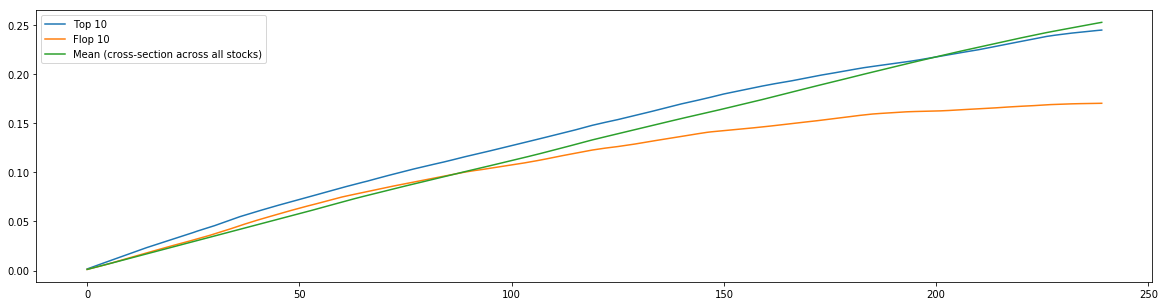

In [173]:
def detect_pattern_in_choie_of_LSTM_RNN(top_10_seq_array,flop_10_seq_array,num_study_period,
                                        data_directory="./train_trade_set/LSTM_RNN"):
    # print(top_10_seq_array.shape)
    # print(flop_10_seq_array.shape)
    top_10_rtn_idx=np.mean(np.cumsum(top_10_seq_array,axis=1),axis=0)
    flop_10_rtn_idx=np.mean(np.cumsum(flop_10_seq_array,axis=1),axis=0)
    trade_X_list=[]
    for study_period_idx in range(num_study_period):
        trade_X=pickle.load(open(data_directory+"/return_trade_X_"+str(study_period_idx),"rb"))
        miu,sigma=pickle.load(open(data_directory+"/return_miu_sigma_"+str(study_period_idx),"rb"))
        trade_X_list.append(trade_X*sigma+miu)
    trade_X_array=np.concatenate(trade_X_list,axis=0)
    all_stock_rtn_idx=np.mean(np.cumsum(trade_X_array,axis=1),axis=0)
    
    plt.figure(figsize=(20,5))
    plt.plot(top_10_rtn_idx,label="Top 10")
    plt.plot(flop_10_rtn_idx,label="Flop 10")
    plt.plot(all_stock_rtn_idx,label="Mean (cross-section across all stocks)")
    plt.legend()
    
detect_pattern_in_choie_of_LSTM_RNN(top_k_seq,flop_k_seq,2)  # 注意最后把2换成num_study_period